In [16]:
import os
import pathlib
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import tensorflow as tf
import tqdm
import xarray as xr
from rasterio.warp import Resampling, calculate_default_transform, reproject
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA

# Suppress all warnings
warnings.filterwarnings("ignore")

# Open dataset
... explain a bit about dataset .. 
.. contents, variables, origin ...

In [17]:
base_dir = pathlib.Path(".").resolve()
base_dir

PosixPath('/Users/baart_f/Library/CloudStorage/OneDrive-SharedLibraries-StichtingDeltares/Tiaravanni Hermawan - Indonesia case for students')

# Multi file dataset
We can also open all the files at once

In [18]:
mf_path = base_dir / "semarang/hydromt_data_1/to_clean/cleaned/mfdata"
paths = list(mf_path.glob("*.nc"))
file_ids = range(len(paths))
data_array = xr.open_mfdataset(paths, combine="nested", concat_dim=[file_ids])
data_array

<xarray.Dataset>
Dimensions:               (concat_dim: 2, y: 767, x: 693)
Coordinates:
  * concat_dim            (concat_dim) int64 0 1
Dimensions without coordinates: y, x
Data variables: (12/13)
    cn_avg                (concat_dim, y, x) float32 dask.array<chunksize=(1, 767, 693), meta=np.ndarray>
    fabdem_sub            (concat_dim, y, x) float32 dask.array<chunksize=(1, 767, 693), meta=np.ndarray>
    flooddepth_sfincs     (concat_dim, y, x) float32 dask.array<chunksize=(1, 767, 693), meta=np.ndarray>
    flood_depth_compound  (concat_dim, y, x) float32 dask.array<chunksize=(1, 767, 693), meta=np.ndarray>
    flwdir                (concat_dim, y, x) float32 dask.array<chunksize=(1, 767, 693), meta=np.ndarray>
    hnd                   (concat_dim, y, x) float32 dask.array<chunksize=(1, 767, 693), meta=np.ndarray>
    ...                    ...
    manning_values        (concat_dim, y, x) float32 dask.array<chunksize=(1, 767, 693), meta=np.ndarray>
    perm_water_p50        (concat_dim, y, x) float32 dask.array<chunksize=(1, 767, 693), meta=np.ndarray>
    population            (concat_dim, y, x) float32 dask.array<chunksize=(1, 767, 693), meta=np.ndarray>
    uparea                (concat_dim, y, x) float32 dask.array<chunksize=(1, 767, 693), meta=np.ndarray>
    vito                  (concat_dim, y, x) float32 dask.array<chunksize=(1, 767, 693), meta=np.ndarray>
    wsf_bld_2015_v1       (concat_dim, y, x) float32 dask.array<chunksize=(1, 767, 693), meta=np.ndarray>

# Prepare
In this step we can reshape data and creat eextra variables. We need two extra variables. 
Here we compute an extra variable mask. This defines our area of interest (mask==0) and ignore unfloodable areas (mask==1). We base this on the flood depth compound. 
We'll also create an extra map of flooded area, based on our SFINCS computations. If it is flooded we can provide extra reward if you calculate this correctly in the right location.


In [20]:
data_array["mask"] = data_array["flood_depth_compound"] <= 0.001
data_array["is_flooded"] = data_array["flooddepth_sfincs"] >= 0.5

# Visualisation
Here we go to the EDA step. After that we'll go back to preparing. We now provide an initial visualisation of some variables.

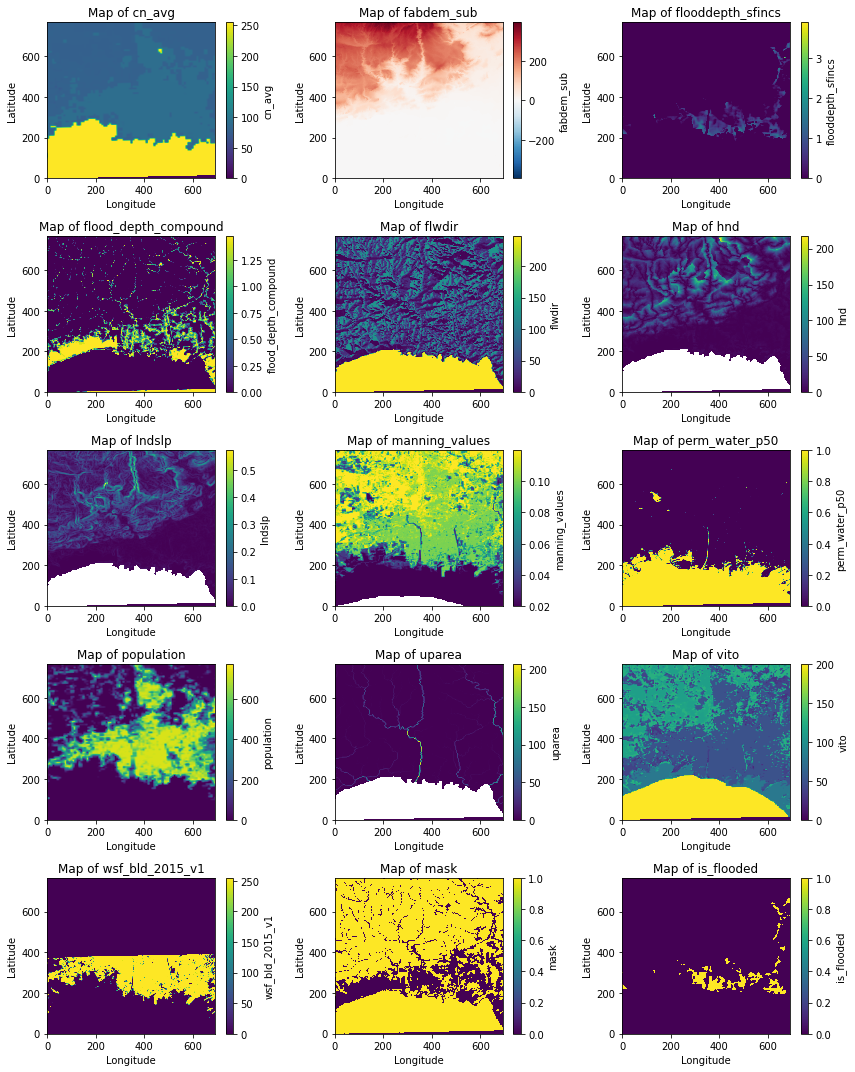

In [39]:
# Get a list of data variables (excluding dimensions and attributes)
data_variables = [
    var 
    for var in data_array.variables 
    if (
        data_array[var].dtype != "S" and
        len(data_array[var].shape) >= 2
    )
]

# Calculate the number of rows needed for the grid (2 columns)
num_vars = len(data_variables)
num_rows = (
    num_vars + 1
) // 3  # Add 1 to round up if there's an odd number of variables

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(12, 3 * num_rows))

# Loop through each variable and create a map in a subplot
for ax, variable_name in zip(axes.flat, data_variables):
    variable = data_array[variable_name][0]
    variable.plot(ax=ax)

    ax.set_title(f"Map of {variable_name}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Prepare for training
Here we will extract all variables in a format that we can use in our neural network. 


In [40]:

img_shape = (128, 128)
# let's define our inputs
tensors = [
    {
        "name": "soil_moisture",
        "var": "cn_avg",
        "shape": img_shape,
        "dtype": "float32",
        "role": "input",
    },
    {
        "name": "flood_hand",
        "var": "flood_depth_compound",
        "shape": img_shape,
        "dtype": "float32",
        "role": "input",
    },
    # static maps
    {
        "name": "elevation",
        "var": "fabdem_sub",
        "shape": img_shape,
        "dtype": "float32",
        "role": "input",
    },
    {
        "name": "is_permanent_water",
        "var": "perm_water_p50",
        "shape": img_shape,
        "dtype": "bool",
        "role": "input",
    },
    {
        "name": "mask",
        "var": "mask",
        "shape": img_shape,
        "dtype": "bool",
        "role": "input",
    },
    {
        "name": "is_flooded",
        "var": "is_flooded",
        "shape": img_shape,
        "dtype": "float32",
        "role": "output",
    },
    {
        "name": "flood_depth",
        "var": "flooddepth_sfincs",
        "shape": img_shape,
        "dtype": "float32",
        "role": "output",
    },
]

In [23]:
def add_tensor_spec(spec):
    for row in spec:
        tensor_spec = tf.TensorSpec(
            shape=row["shape"], dtype=row["dtype"], name=row["name"]
        )
        row["tensor_spec"] = tensor_spec
    return spec


specs = add_tensor_spec(tensors)
specs

[{'name': 'precipitation',
  'var': 'cn_avg',
  'shape': (64, 64),
  'dtype': 'float32',
  'role': 'input',
  'tensor_spec': TensorSpec(shape=(64, 64), dtype=tf.float32, name='precipitation')},
 {'name': 'flood_hand',
  'var': 'flood_depth_compound',
  'shape': (64, 64),
  'dtype': 'float32',
  'role': 'input',
  'tensor_spec': TensorSpec(shape=(64, 64), dtype=tf.float32, name='flood_hand')},
 {'name': 'elevation',
  'var': 'fabdem_sub',
  'shape': (64, 64),
  'dtype': 'float32',
  'role': 'input',
  'tensor_spec': TensorSpec(shape=(64, 64), dtype=tf.float32, name='elevation')},
 {'name': 'is_permanent_water',
  'var': 'perm_water_p50',
  'shape': (64, 64),
  'dtype': 'bool',
  'role': 'input',
  'tensor_spec': TensorSpec(shape=(64, 64), dtype=tf.bool, name='is_permanent_water')},
 {'name': 'mask',
  'var': 'mask',
  'shape': (64, 64),
  'dtype': 'bool',
  'role': 'input',
  'tensor_spec': TensorSpec(shape=(64, 64), dtype=tf.bool, name='mask')},
 {'name': 'is_flooded',
  'var': 'is_flo

In [42]:
def array_to_examples(data_array, specs, n_samples=8, n_flood_limit=9):
    # use a random number generator to permute the data
    rng = np.random.default_rng()

    # take a quarter overlapping windows (each next window is 75% the same as the previous one)
    window_interval = img_shape[0] // 4
    window_slice = np.s_[::window_interval, ::window_interval]

    # loop over all variables to generate slicing windows
    for row in specs:
        if row["name"] == "mask":
            continue
        arr = data_array[row["var"]].values
        row["arr"] = arr
        row["all_windows"] = np.lib.stride_tricks.sliding_window_view(
            arr, window_shape=img_shape
        )

        # samples from the windows
        row["sliced_windows"] = row["all_windows"][window_slice].reshape(-1, *img_shape)

    # as a special case we will slice over the mask
    mask = data_array["mask"].values
    mask_windows = np.lib.stride_tricks.sliding_window_view(
        mask, window_shape=img_shape
    )
    sliced_mask = mask_windows[window_slice].reshape(-1, *img_shape)
    n_flood = np.prod(img_shape) - sliced_mask.sum(axis=(1, 2))
    n_windows = sliced_mask.shape[0]

    # now let's loop over all possible windows until we have our number of samples
    idx = np.arange(n_windows)
    # we shuffle the data, so we're sampling without replacement
    # take a random idx here if you want to sample with replacement
    shuffled_idx = rng.permuted(idx)

    # keep track of how many samples we generated
    n_generated_samples = 0
    for idx_i in shuffled_idx:
        # stop if done
        if n_generated_samples >= n_samples:
            break
        # check if this sample is valid (minimum # pixels flooded)
        if n_flood[idx_i] < n_flood_limit:
            continue

        # create an example
        example = {}
        for row in specs:
            if row["name"] == "mask":
                # do not read data from sliced_window but from sliced_mask
                example["mask"] = sliced_mask[idx_i, ...]
                continue
            # for other variables
            sample = row["sliced_windows"][idx_i, ...]
            sample_n_flood = n_flood[idx_i]
            example[row["name"]] = sample

        # yield the example
        yield example
        n_generated_samples += 1

# Sampling scheme

In [43]:
img_shape = (128, 128)
n_samples = 8
examples = []
for case in data_array.concat_dim:
    for example in array_to_examples(
        data_array=data_array.sel(concat_dim=case), specs=specs, n_samples=n_samples
    ):
        examples.append(example)

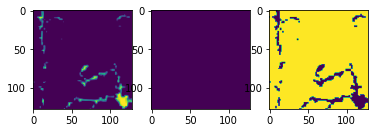

In [44]:
fig, axes = plt.subplots(ncols=3)
axes[0].imshow(examples[0]["flood_hand"])
axes[1].imshow(examples[0]["flood_depth"])
axes[2].imshow(examples[0]["mask"])

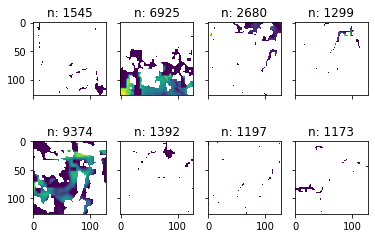

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True)

variable = "flood_depth"
for ax, example_i in zip(axes.flat, examples):
    arr_ma = np.ma.masked_array(example_i[variable], example_i["mask"])
    n_unmasked = (~example_i["mask"]).sum()
    ax.imshow(arr_ma)
    ax.set_title(f"n: {n_unmasked}")

# Old EDA code (convert to new file format)

In [30]:
# Create an empty dataframe to store the statistics
columns = ["Raster", "Mean", "Standard Deviation", "Median"]
df = pd.DataFrame(columns=columns)

# Loop through each raster in the dataset, compute statistics, and append to the dataframe
for raster_name, raster_data in data_array.items():
    min = raster_data.min().item()
    max = raster_data.max().item()
    mean = raster_data.mean().item()
    std = raster_data.std().item()
    median = raster_data.median().item()
    df = df.append(
        {
            "Raster": raster_name,
            "Min": min,
            "Max": max,
            "Mean": mean,
            "Standard Deviation": std,
            "Median": median,
        },
        ignore_index=True,
    )

# Set the decimal separator to dot
pd.options.display.float_format = "{:.2f}".format

# Print the dataframe
print(df)

NotImplementedError: 'item' is not yet a valid method on dask arrays

In [31]:
# Vectorize the data_array into a pandas DataFrame
data_dict = {}
for var_name in data_array.data_vars:
    data_dict[var_name] = data_array[var_name].values.flatten()

df = pd.DataFrame(data_dict)

In [ ]:
# Create a pairplot using Seaborn
sns.set(style="ticks")
plt = sns.pairplot(df)
output_filename = "pairplot.png"
plt.savefig(output_filename)

In [ ]:
df

In [ ]:
# Create a PCA instance with n_components=3
pca = PCA(n_components=3)

# Fit PCA to the data
pca.fit(df.dropna())

# Calculate explained variance ratio, singular values, and cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_
exp_var_cumul = np.cumsum(explained_variance_ratio)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), exp_var_cumul, marker="o")

# Set labels and title
plt.xlabel("Number of principal components")
plt.ylabel("Explained variance")
plt.title("Cumulative Explained Variance by Principal Components")

# Set y-axis limits
plt.ylim(0, 1)

# Set x-axis ticks as integers
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1, 1))

# Show grid
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
Y = df.dropna()["flooddepth_sfincs"]
X = df.dropna().drop(columns=["flooddepth_sfincs"])

In [ ]:
# PLS
pls2 = PLSRegression(n_components=2)
pls2.fit(X, Y)  # X, Y
Y_pred = pls2.predict(X)

In [ ]:
# Calculate Spearman's correlation matrix
corr_matrix = df.corr(method="spearman")

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5, vmin=-1, vmax=1
)
plt.title("Spearman's Correlation Heatmap")
plt.show()